# Rosenzweig-MacArthur

The Rosenzweig-MacArthur equations add more realistic logistic growth in the prey population and intake rates in the predation population. Logistic growth is simulated the same as the implicit single population example. The predator intake rate is a Hollings type II functional response &mdash; as prey population increase, predator intake rates plateau due to some physical limit in capturing, handling, and converting prey to offspring. A type II functional response can be recreated in an IEBM by adding a *PauseEvent*. A *PauseEvent* is triggered after and *InteractEvent*, sets the velocity of an individual to zero, and adds an event to the heap that eventually resumes activities. The equations are:

$\frac{dN}{dt} = rN(1 - \frac{N}{k}) - \frac{\alpha N P}{A + \alpha h N}$

$\frac{dP}{dt} = \frac{\varepsilon \alpha N P}{A + \alpha h N} - \delta P $

The two new parameters are $k$, the carrying capacity of the prey, and $h$, the handling time of the predator consuming the prey. 

Here is a recreation of the model as an IEBM and comparison with the ironic ODE dynamics.

In [1]:
%matplotlib inline
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from multiprocessing import Pool
from tqdm import tqdm
import warnings

# import datatime to set threads to 1
# allows for better multiprocessing
import datatable as dt
dt.options.nthreads = 1

# set nice plotting style
plt.style.use('bmh')

## Parameters
Set parameters that are used in both the ODE and IEBM. Values selected to have small populations for faster simulations.

In [2]:
r = 0.001 # prey growth rate
a = 1 # predator attack rate
c = 1 # predator conversion efficiency
d = 0.001 # predator death rate
# size of environment
xdim = 500
ydim = 500
A = xdim * ydim
init_prey = 100 # starting prey population size
init_pred = 100 # starting predator population size
h = 75
# set the simulation time to certain number of cycles

time = 100000
ode_step = 200
ode_times = np.linspace(0, time, ode_step)

# for the IEBM, individuals need explicit size
prey_radius = 1
pred_radius = 1

## Create Bifurcation Plot
For a given set of parameters, increasing the carrying capacity of the prey can ironically destabilize the predator population. The ODE is intergrated over a range of carrying capacities affect the minium and maximum values of the predator populations

In [3]:
def ode_k(k):
    
    def dN_dt(N, t=0):
        return np.array([r*N[0]*(1-N[0]/k) - (a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]),
                         c*(a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]) - d*N[1]])
    
    X, info = integrate.odeint(dN_dt, [init_prey, init_pred], ode_times, full_output=1)
    #ode_prey = X[:, 0]
    ode_pred = X[:, 1] 
    
    #prey = ode_prey[len(ode_prey)//2:]
    pred = ode_pred[len(ode_pred)//2:]
    
    return [k, pred.min(), pred.max()]

In [4]:
ks = np.linspace(100,10000, 200)

pbar = tqdm(total=len(ks))

res = []
def update(a):
    res.append(a)
    pbar.update()

pool = Pool()

for k in ks:
    pool.apply_async(ode_k, (k,), 
                     callback=update)

pool.close()
pool.join()
pbar.close()

res = pd.DataFrame(res, columns=['k', 'pred_min', 'pred_max'])

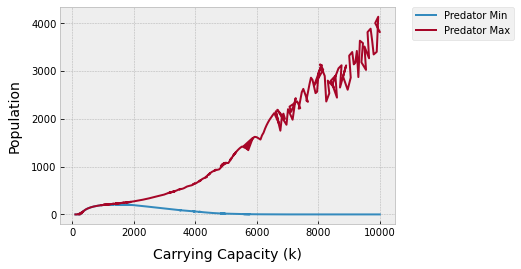

In [5]:
fig, ax = plt.subplots()
ax.plot(res.k, res.pred_min, label='Predator Min')
ax.plot(res.k, res.pred_max, label='Predator Max')
ax.set_xlabel('Carrying Capacity (k)', labelpad=10, fontsize=14)
ax.set_ylabel('Population', labelpad=10, fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
plt.show()

## ODE and IEBM comparison
The ODE dynamics at several carrying capacities are compared with a recreated IEBM.

In [6]:
# function to get integration results of an ODE with a set carrying capacity
def run_ode(k):
    
    ode_times = np.linspace(0, time, ode_step) # inference times

    # create exponential growth equation as a function of N
    def dN_dt(N, t=0):
        return np.array([r*N[0]*(1-N[0]/k) - (a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]),
                         c*(a/A)*N[0]*N[1]/(1+(a/A)*h*N[0]) - d*N[1]])

    # integrate growth equation
    X, info = integrate.odeint(dN_dt, [init_prey, init_pred], ode_times, full_output=1)
    # format and store results
    ode_prey = X[:, 0]
    ode_pred = X[:, 1]     
    
    return ode_prey, ode_pred

In [7]:
# point path to IEBM files
import sys
sys.path.append('../../')
# model population in 2-dimensions
from iebm.populations.population2D import Population2D
# import Trait classes to set up Events
from iebm.traits.static_trait import StaticTrait
from iebm.traits.linked_trait import LinkedTrait
# import BirthAsexualEvent for the prey
from iebm.events.birth_asexual import BirthAsexualEvent
# import DeathEvent for the predator
from iebm.events.death import DeathEvent
# movement is simulated by time to boundary (wall) events
from iebm.events.wall import WallEvent
# import 2D interaction for 2D populations
from iebm.events.interact2d import Interact2DEvent
# import class to simulate model
from iebm.simulation import Simulation
# event that pauses an individual for an alloted time
from iebm.events.pause import Pause2DEvent

In [8]:
# function to setup an Rosenzweig-MacArthur model with a different carrying capacities
def rm_setup(k):

    # start with two blank populations
    # note the prey population has an implicit carrying capacity
    prey = Population2D(name='prey', init_size=init_prey, xdim=xdim, ydim=ydim, implicit_capacity=k)
    pred = Population2D(name='pred', init_size=init_pred, xdim=xdim, ydim=ydim)

    # with a stationary prey, the relative velocity to achive the same attack rate is:
    vel = a / (2 * (prey_radius + pred_radius))

    trait_prey = [(StaticTrait, {'name' : 'birth_rate', 
                                 'value' : r}), 
                  (StaticTrait, {'name' : 'radius', 
                                 'value' : prey_radius}),
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x : x})]

    event_prey = [(BirthAsexualEvent, {'name' : 'birth' , 
                                       'is_primary' : True,
                                       'current_time' : 0}), 
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : False, 
                                'current_time' : 0})]

    trait_pred = [(StaticTrait, {'name' : 'radius', 
                                 'value' : pred_radius}), 
                  (LinkedTrait, {'name' : 'predation_radius', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x}),
                  (StaticTrait, {'name' : 'velocity', 
                                 'value' : vel}),
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : d}), 
                  (StaticTrait, {'name' : 'handling', 
                                 'value' : h})]
    
    # note the new PauseEvent that has an ignore_list
    # these are events that can occur while an individual is
    # inactive, in this case, death is still possible.
    # the other new piece is the trigger_set_next in the interaction.
    # usually events set_next after occuring, but since there's a pause,
    # the next interaction is set after the pause trigger.
    event_pred = [(DeathEvent, {'name' : 'death',
                                'is_primary' : True,
                                'current_time' : 0}), 
                  (WallEvent, {'name' : 'wall', 
                               'is_primary' : True, 
                               'current_time' : 0, 
                               'bounce' : 'random'}), 
                  (Interact2DEvent, {'name' : 'predation',
                                     'is_primary' : True,
                                     'tirgger_set_next' : True,
                                     'current_time'  : 0, 
                                     'other' : prey}), 
                  (Pause2DEvent, {'name' : 'handling',
                                  'ignore_list' : ['death'],
                                  'is_primary' : False}),
                  (BirthAsexualEvent, {'name' : 'birth', 
                                       'is_primary' : False, 
                                       'current_time' : 0})]   
    
    return prey, pred, trait_prey, trait_pred, event_prey, event_pred

In [9]:
# function to run a Rosenzweig-MacArthur model from the returned value of rm_setup.
def rm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=True):
    
    prey.add_traits(trait_prey)
    prey.add_events(event_prey)
    pred.add_traits(trait_pred)
    pred.add_events(event_pred)    
    
    # list what events to stop at pause
    set_list = [c for c in pred.event_list if c not in pred.event_dict['handling'].ignore_list]
    pred.event_dict['handling'].set_list = set_list
    
    # trigger interaction == pause == birth

    # add event triggers to finish setting up system
    # when new prey is born, check and create new predation collisions
    prey.event_dict['birth'].triggers = pred.event_dict['predation'].set_other_next

    # set the trigger for a predation interaction event
    # a few things occur at a predation event, so we need a function
    def predation_trigger(params):
        events = []
        other_params = params.copy()
        other_params['actor_id'] = other_params['extra']
        # the prey is removed
        events += prey.event_dict['death'].handle(other_params)
        # the predator pauses to handle 
        events += pred.event_dict['handling'].set_next(params)
        return events
    pred.event_dict['predation'].triggers = predation_trigger

    # after handling, predator can give birth and get new settings
    def handle_trigger(params):
        events = []
        # now that individual is active:
        # set new wall times
        pred.event_dict['wall'].set_next(params)
        # set next predation times
        pred.event_dict['predation'].set_next(params)
        # possibly create offspring after handling
        events += pred.event_dict['birth'].handle(params)
        # get individual's next evet
        events += [pred.get_next_event(params['actor_id'])]
        return events
    pred.event_dict['handling'].triggers = handle_trigger

    # set triggers to calculate new interactions after wall collision
    pred.event_dict['wall'].triggers = pred.event_dict['predation'].set_next
    
    # add the pops to a dictionary 
    pop_dict = {str(prey) : prey, 
                str(pred) : pred}

    # create the simulation with the population dictionary
    sim = Simulation(pop_dict)
    
    # run simulation
    sim.run(time, progress_bar=progress_bar)

    # return simulation resuls
    res = sim.get_results()
    
    return res

In [10]:
# function to run in parallel
def run_parallel(k):
    
    prey, pred, trait_prey, trait_pred, event_prey, event_pred = rm_setup(k)
    res = rm_model(prey, pred, trait_prey, trait_pred, event_prey, event_pred, progress_bar=False)  
    
    return [k, res]

In [11]:
# run IEBM a few times on select carrying capacties

ks = [1000, 2000, 4000, 8000]
runs = 8 #99
ks = [k for k in ks for _ in range(runs)]

pbar = tqdm(total=len(ks))

res = []
def update(a):
    res.append(a)
    pbar.update()

pool = Pool()

for k in ks:
    pool.apply_async(run_parallel, (k,), 
                     callback=update)

pool.close()
pool.join()
pbar.close()

res = pd.DataFrame(res, columns = ['k', 'out'])

In [12]:
# format parallel results

res_df = []
for k, g in res.groupby('k'):
    all_temp = []
    for go in g.out:
        temp_df = pd.DataFrame()
        temp_df['time'] = go['time']
        for p in go['size']:
            temp_df[p] = go['size'][p] 
        all_temp.append(temp_df)
    all_temp = pd.concat(all_temp, ignore_index=True)
    all_temp['k'] = k
    res_df.append(all_temp)

# combine runs by averaging at integer time stamps
res_df = pd.concat(res_df, ignore_index=True)
res_df['time_int'] = res_df['time'].astype(np.int64)
res_grp = res_df.groupby(['k', 'time_int']).agg({'prey' : np.mean, 'pred' : np.mean}).reset_index()

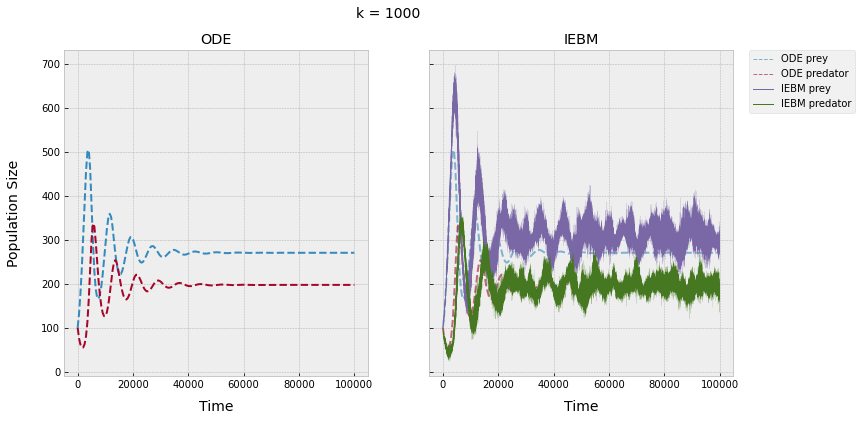

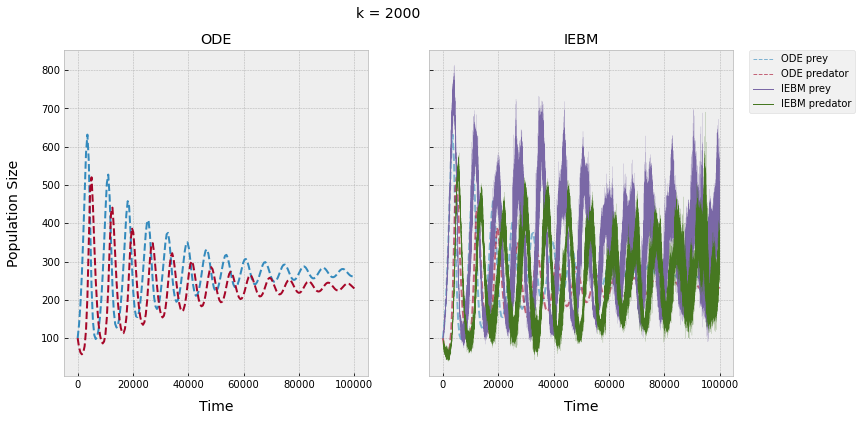

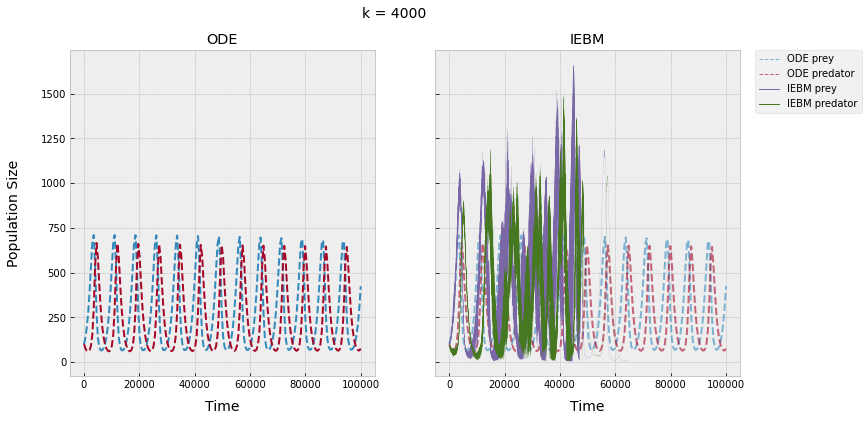

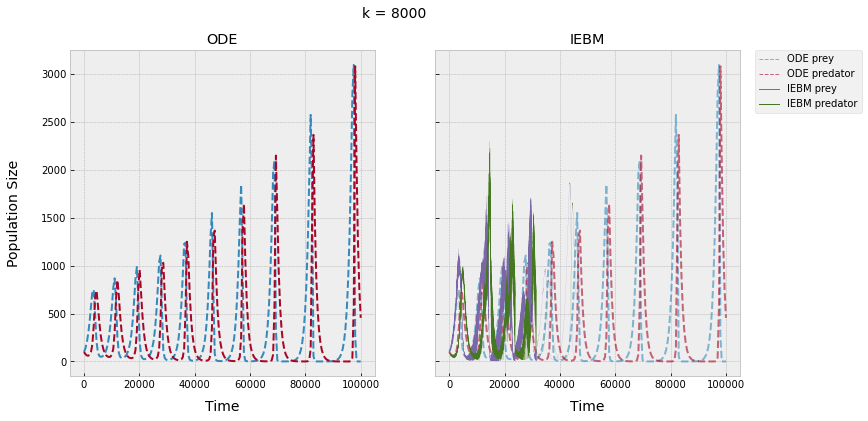

In [23]:
for k,g in res_grp.groupby('k'):
    
    ode_prey, ode_pred = run_ode(k)
    
    fig, ax = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

    ax[0].plot(ode_times, ode_prey, label='ODE prey', ls='--')
    ax[0].plot(ode_times, ode_pred, label='ODE predator', ls='--')
    ax[0].set_title('ODE')
    ax[0].set_ylabel('Population Size', labelpad=20, fontsize=14)
    ax[0].set_xlabel('Time', labelpad=10, fontsize=14)

    ax[1].plot(ode_times, ode_prey, label='ODE prey', ls='--', alpha=0.6)
    ax[1].plot(ode_times, ode_pred, label='ODE predator', ls='--', alpha=0.6)
    ax[1].plot(g.time_int, g.prey, label='IEBM prey', lw=0.1)
    ax[1].plot(g.time_int, g.pred, label='IEBM predator', lw=0.1)
    ax[1].set_title('IEBM')
    ax[1].set_xlabel('Time', labelpad=10, fontsize=14)

    leg = plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1)
    plt.suptitle(f'k = {k}', fontsize=14)
    plt.show()    